In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan

    
    
tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')

fourier_1 = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_1.npy')


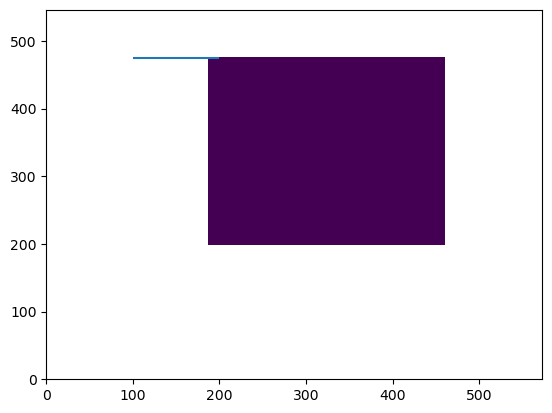

In [5]:
plt.pcolormesh(fourier_1)
plt.hlines(475, xmin=100, xmax=200)

In [6]:
# now it's a square in distance space, not in angular space

index = np.argwhere(fourier_1 == 1.)
latsss = index[:,0]; lonsss = index[:,1]
fourier_1[np.unique(latsss)[-5:], :] = np.nan

index = np.argwhere(fourier_1 == 1.)
latsss = index[:,0]; lonsss = index[:,1]

In [7]:
ds_sst = xr.open_dataset('/venus/tesi_ale/data_EU/SST/hourly/FEB/dSST_feb.nc')
dsst_day = ds_sst['dsst_day'].values[:, latsss, lonsss]   #*fourier_1

In [10]:
dsst_day = dsst_day.reshape(29, 273, 273)

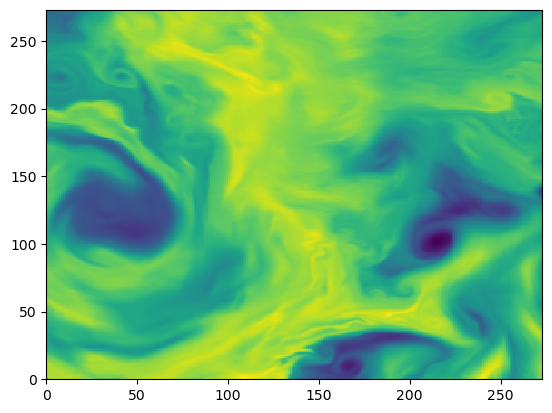

In [11]:
plt.pcolormesh(dsst_day[0])

# A very dirty try

In [17]:
dsst_spectr = np.fft.fft2(dsst_day[0])
dsst_spectr_ampl = np.abs(dsst_spectr)
dsst_spectr_phase = np.angle(dsst_spectr)

# shift the zero-frequency component at the centre of the spectrum
dsst_spectr_centred = np.fft.fftshift(dsst_spectr)
dsst_spectr_centr_ampl = np.abs(dsst_spectr_centred)
dsst_spectr_centr_phase = np.angle(dsst_spectr_centred)

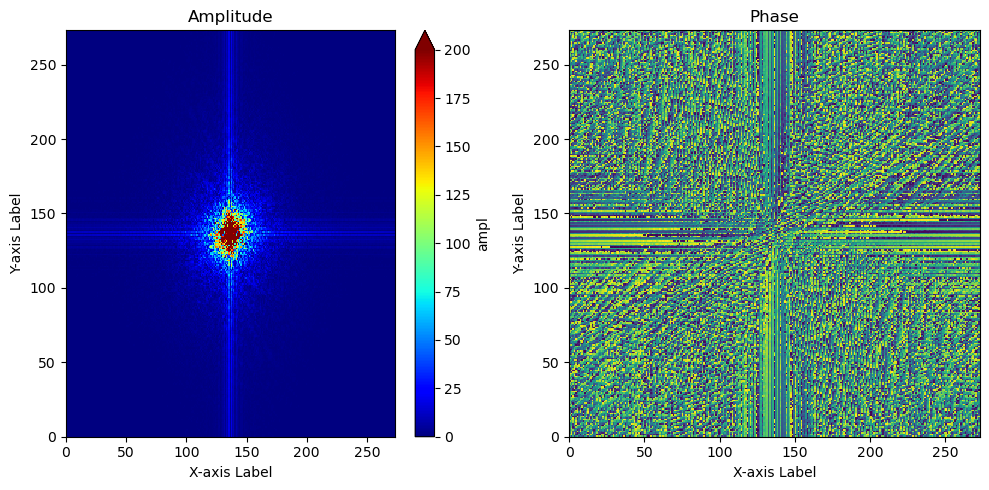

In [18]:

# Create a figure and 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot (left)
im = axes[0].pcolormesh(dsst_spectr_centr_ampl, vmin=0, vmax=200, cmap='jet')
cbar = plt.colorbar(im, ax=axes[0], extend='max')
cbar.set_label('ampl')

axes[0].set_title('Amplitude')
axes[0].set_xlabel('X-axis Label')
axes[0].set_ylabel('Y-axis Label')

# Second subplot (right)
axes[1].pcolormesh(dsst_spectr_centr_phase)
axes[1].set_title('Phase')
axes[1].set_xlabel('X-axis Label')
axes[1].set_ylabel('Y-axis Label')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


https://stackoverflow.com/questions/66977714/generating-new-2d-data-using-power-spectrum-density-function-from-spatial-freque

https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/

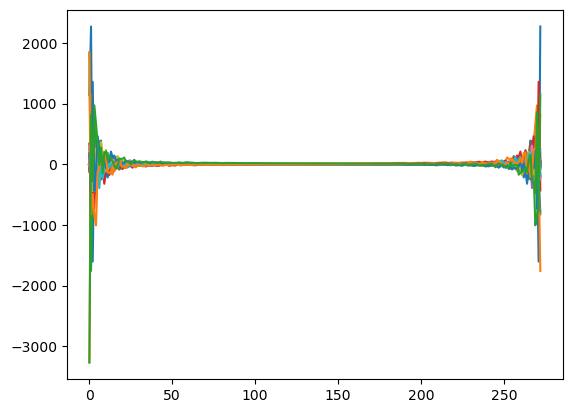

In [52]:
fourier_image = np.fft.fft2(dsst_day[0])
#fourier_image = np.fft.fftshift(fourier_image)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

plt.plot(fourier_image)